In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import lasio
from pyesmda import ESMDA
from scipy.io import loadmat
from numdifftools import Jacobian, Hessian
from scipy import signal, stats, linalg, optimize

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

def check_torch():
    torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
    count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
    print('\n'+'-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
    print('# Device(s) available: {}, Name(s): {}'.format(count, name))
    print('-'*60+'\n')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

device = check_torch()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.7.1+cu126 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------



In [41]:
def plot_curve(ax, df, curve, lb=None, ub=None, color='k', pad=0, s=2, ms=2, mult=1,
            units:str=None, mask=None, offset:int=0, title:str=None, label:str=None,
            semilog:bool=False, bar:bool=False, fill:bool=None, rightfill:bool=False,
            marker=None, edgecolor=None, ls=None, alpha=None, grid_alpha=0.5, zorder=1):
        if mask is None:
            x, y = -offset+mult*df[curve], df.index
        else:
            x, y = -offset+mult*df[curve][mask], df.index[mask]
        lb = x[~np.isnan(x)].min() if lb is None else lb
        ub = x[~np.isnan(x)].max() if ub is None else ub
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha, zorder=zorder,
                        marker=marker, markersize=ms, markeredgecolor=edgecolor, linestyle=ls, linewidth=s)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha, zorder=zorder)
            else:
                ax.plot(x, y, c=color, label=curve, alpha=alpha, marker=marker, markersize=ms, markeredgecolor=edgecolor, 
                        linewidth=s, linestyle=ls, zorder=zorder)
        if fill:
            if rightfill:
                ax.fill_betweenx(y, x, ub, alpha=alpha, color=color, zorder=zorder)
            else:
                ax.fill_betweenx(y, lb, x, alpha=alpha, color=color, zorder=zorder)
        if units is None:
            if hasattr(df, 'curvesdict'):
                units = df.curvesdict[curve].unit
            else:
                units = ''
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both',alpha=grid_alpha)
        ax.set_title(title, weight='bold') if title != None else None
        xlab = label if label is not None else curve
        if offset != 0:
            ax.set_xlabel('{} [{}] with {} offset'.format(xlab, units, offset), color=color, weight='bold')
        else:
            ax.set_xlabel('{} [{}]'.format(xlab, units), color=color, weight='bold')
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=s)
        ax.spines['top'].set_position(('axes', 1+pad/100))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(2)
        if ls is not None:
            ax.spines['top'].set_linestyle(ls)
        return None

def plot_loss(losses_df, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.plot(losses_df['train'], label='Training')
    plt.plot(losses_df['valid'], label='Validation')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xlim(0, losses_df.shape[0]); plt.ylim(0, None)
    plt.grid(True, which='both'); plt.legend()
    plt.tight_layout(); plt.show()
    return None

In [3]:
class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult * torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

class PINNLoss(nn.Module):
    def __init__(self, dd_flag:bool=True, ddmax=1.0, lambda_reg=1e-10, lambda_p=2):
        super(PINNLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p   = lambda_p
        self.dd_flag    = dd_flag
        self.ddmax      = ddmax

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]/self.ddmax
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]
        
        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        eq1 = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = (1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        if self.dd_flag:
            wd1, wd2 = 1/Rv_true/dd_true, 1/Rh_true/dd_true
        else:
            wd1, wd2 = 1/Rv_true, 1/Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg * torch.norm(outputs, p=self.lambda_p)

        return  costf + regPa
    
class DataLoss(nn.Module):
    def __init__(self, loss_fn=nn.MSELoss(), lambda_p=2):
        super(DataLoss, self).__init__()
        self.dd_loss = loss_fn
        self.lambda_p = lambda_p

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]
        
        Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
        Rh_sim = 1 / (Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
        v_loss = self.dd_loss(Rv_sim, Rv_true)
        h_loss = self.dd_loss(Rh_sim, Rh_true)
        
        return torch.norm(torch.stack([v_loss, h_loss], dim=-1), p=self.lambda_p)

In [4]:
def esmda_assimilation(X_prior, y_obs, obs_idx, R=None, n_iter=4, gamma=1.5, filt:bool=True, filt_kernel=(1,5)):
    n_ens, n_state = X_prior.shape
    n_obs = len(obs_idx)
    H = np.eye(n_state)[obs_idx]
    alpha1 = (1-gamma) / (1-gamma**n_iter)
    alpha_factors = np.array([alpha1 * gamma**(i) for i in range(n_iter)])
    if R is None:
        R = np.eye(n_obs) * 0.05
    X = X_prior.copy()
    for i in range(n_iter):
        Y = X @ H.T
        A = X - X.mean(axis=0)
        YA = Y - Y.mean(axis=0)
        alpha = alpha_factors[i]
        R_scaled = R * alpha
        Y_pert = y_obs + np.random.multivariate_normal(np.zeros(n_obs), R_scaled, size=n_ens)
        Cxy = (A.T @ YA) / (n_ens - 1)
        Cyy = (YA.T @ YA) / (n_ens - 1) + R_scaled
        K = Cxy @ linalg.pinv(Cyy)
        X += (Y_pert - Y) @ K.T
    return signal.medfilt(X, kernel_size=filt_kernel) if filt else X

def esmda_parameter_estimation(theta_prior, y_obs, obs_idx, forward_model, R=None, n_iter=4, gamma=1.5, log:bool=False):
    n_ens, n_params = theta_prior.shape
    n_obs = len(y_obs)
    if log:
        y_obs = np.log10(y_obs)
    alpha1 = (1 - gamma) / (1 - gamma**n_iter)
    alpha_factors = np.array([alpha1 * gamma**(i) for i in range(n_iter)])
    R = np.eye(n_obs) * 0.05 if R is None else R
    theta = theta_prior.copy()
    for i in range(n_iter):
        alpha = alpha_factors[i]
        R_scaled = R * alpha
        Y = forward_model(theta)[:, obs_idx]
        if log:
            Y = np.log10(Y)
        Y_pert = y_obs + np.random.multivariate_normal(np.zeros(n_obs), R_scaled, size=n_ens)
        A_theta = theta - theta.mean(axis=0)
        A_Y = Y - Y.mean(axis=0)
        Cxy = (A_theta.T @ A_Y) / (n_ens - 1)
        Cyy = (A_Y.T @ A_Y) / (n_ens - 1) + R_scaled
        K = Cxy @ linalg.pinv(Cyy)
        theta += (Y_pert - Y) @ K.T
    return theta

In [5]:
def calculate_uncertainty(core, log, pinn, prior, posterior, lb=10, ub=90, decimals:int=3):
    u_core = np.percentile(core, ub) - np.percentile(core, lb)
    u_log = np.percentile(log, ub) - np.percentile(log, lb)
    u_pinn = np.percentile(pinn, ub) - np.percentile(pinn, lb)
    u_prior = np.percentile(prior, ub) - np.percentile(prior, lb)
    u_post = np.percentile(posterior, ub) - np.percentile(posterior, lb)
    uu = {'core': u_core, 'log': u_log, 'pinn': u_pinn, 'prior': u_prior, 'post': u_post}
    
    diff_log = np.abs((u_log - u_core) / u_core) * 100
    diff_pinn = np.abs((u_pinn - u_core) / u_core) * 100
    diff_prior = np.abs((u_prior - u_core) / u_core) * 100
    diff_post = np.abs((u_post - u_core) / u_core) * 100
    dd = {'log': diff_log, 'pinn': diff_pinn, 'prior': diff_prior, 'post': diff_post}

    dyk_core = (np.percentile(core, 50) - np.percentile(core, 15.9)) / np.percentile(core, 50)
    dyk_log = (np.percentile(log, 50) - np.percentile(log, 15.9)) / np.percentile(log, 50)
    dyk_pinn = (np.percentile(pinn, 50) - np.percentile(pinn, 15.9)) / np.percentile(pinn, 50)
    dyk_prior = (np.percentile(prior, 50) - np.percentile(prior, 15.9)) / np.percentile(prior, 50)
    dyk_post = (np.percentile(posterior, 50) - np.percentile(posterior, 15.9)) / np.percentile(posterior, 50)
    dyk = {'core': dyk_core, 'log': dyk_log, 'pinn': dyk_pinn, 'prior': dyk_prior, 'post': dyk_post}
    
    ratio_log = dyk_log / dyk_core
    ratio_pinn = dyk_pinn / dyk_core
    ratio_prior = dyk_prior / dyk_core
    ratio_post = dyk_post / dyk_core
    ratio = {'log': ratio_log, 'pinn': ratio_pinn, 'prior': ratio_prior, 'post': ratio_post}
    
    print('Uncertainty:      Core={:.3f} | Log={:.3f} | PINN={:.3f} | Prior={:.3f} | Posterior={:.3f}'.format(u_core, u_log, u_pinn, u_prior, u_post))
    print('Uncertainty Diff:               Log={:.2f} | PINN={:.2f} | Prior={:.2f} | Posterior={:.2f}'.format(diff_log, diff_pinn, diff_prior, diff_post))
    print('Dykstra-Parsons:  Core={:.3f} | Log={:.3f} | PINN={:.3f} | Prior={:.3f} | Posterior={:.3f}'.format(dyk_core, dyk_log, dyk_pinn, dyk_prior, dyk_post))
    print('Dykstra-Parsons Ratio:          Log={:.3f} | PINN={:.3f} | Prior={:.3f} | Posterior={:.3f}'.format(ratio_log, ratio_pinn, ratio_prior, ratio_post))
    return uu, dd, dyk, ratio


In [7]:
def plot_pdf(ax, dd, color:str='k', label:str=None, alpha:float=0.5, npts:int=500, mult=1, lw=2):
    kde = stats.gaussian_kde(dd)
    xx = np.linspace(dd.min(), dd.max(), npts)
    yy = kde(xx) * mult
    ax.plot(xx, yy, color=color, label=label, lw=lw)
    ax.fill_between(xx, yy, color=color, alpha=alpha)
    return None

***
# Dataset 2 analysis

In [8]:
# North Sea (project)
start, end = 6750, 8750

d2 = lasio.read('datasets/project_data/25_10-16 S.LAS').df().dropna().loc[start:end]
c2 = lasio.read('datasets/project_data/25_10-16 S_Core.las').df()
print(d2.shape, c2.shape)

(8001, 18) (36358, 5)


In [9]:
# clean sand, clean shale (6828.0, 7510.5)
sand_point, shale_point = 6828.0, 7510.5
print('Shale point: {:.1f} | Sand point: {:.1f}'.format(shale_point, sand_point))

# Csh (gamma ray index 'igr')
d2['Rvsh'], d2['Rhsh'] = 2.78, 0.58
gmin, gmax = d2['HCGR'].min(), d2['HCGR'].max()
d2['igr'] = (d2['HCGR'] - gmin) / (gmax - gmin)
csh = MinMaxScaler((0.005,0.995)).fit_transform(d2['igr'].values.reshape(-1, 1)).flatten()

# porosity
d2['PHID_SS'] = (2.65 - d2['RHOZ'].dropna()) / (2.65 - 1)
phi_d_corr = (d2['PHID_SS'] - csh * d2.loc[shale_point, 'PHID_SS']) / (1-csh)
phi_n_corr = (d2['TNPH'] - csh * d2.loc[shale_point, 'TNPH']) / (1-csh)
phi_ss = 0.5*np.sqrt(phi_d_corr**2 + phi_n_corr**2)
d2['phi_t'] = (1-csh)*phi_ss + csh*phi_ss.loc[shale_point]

# resistivity & saturation
a, m, n = 1.0, 2.3, 2.0
rw = d2['AT90'][sand_point] * d2['PHID_SS'][sand_point]**m
rs = (1-csh) / ((1/d2['AT10'])-(csh/d2['AT10'].loc[shale_point]))
sw = ((a*rw) / (rs*d2['phi_t']**m))**(1/n)
d2['sw'] = sw.interpolate('polynomial', order=5).clip(0.01,0.99)
d2['shc'] = 1-d2['sw']

# permeability | a[100,1000], b[2,4], c[1.5,4]
aa, bb, cc = 10, 2.5, 1.5
d2['perm'] = (aa * d2['phi_t']**bb) / (d2['sw']**cc)

Shale point: 7510.5 | Sand point: 6828.0


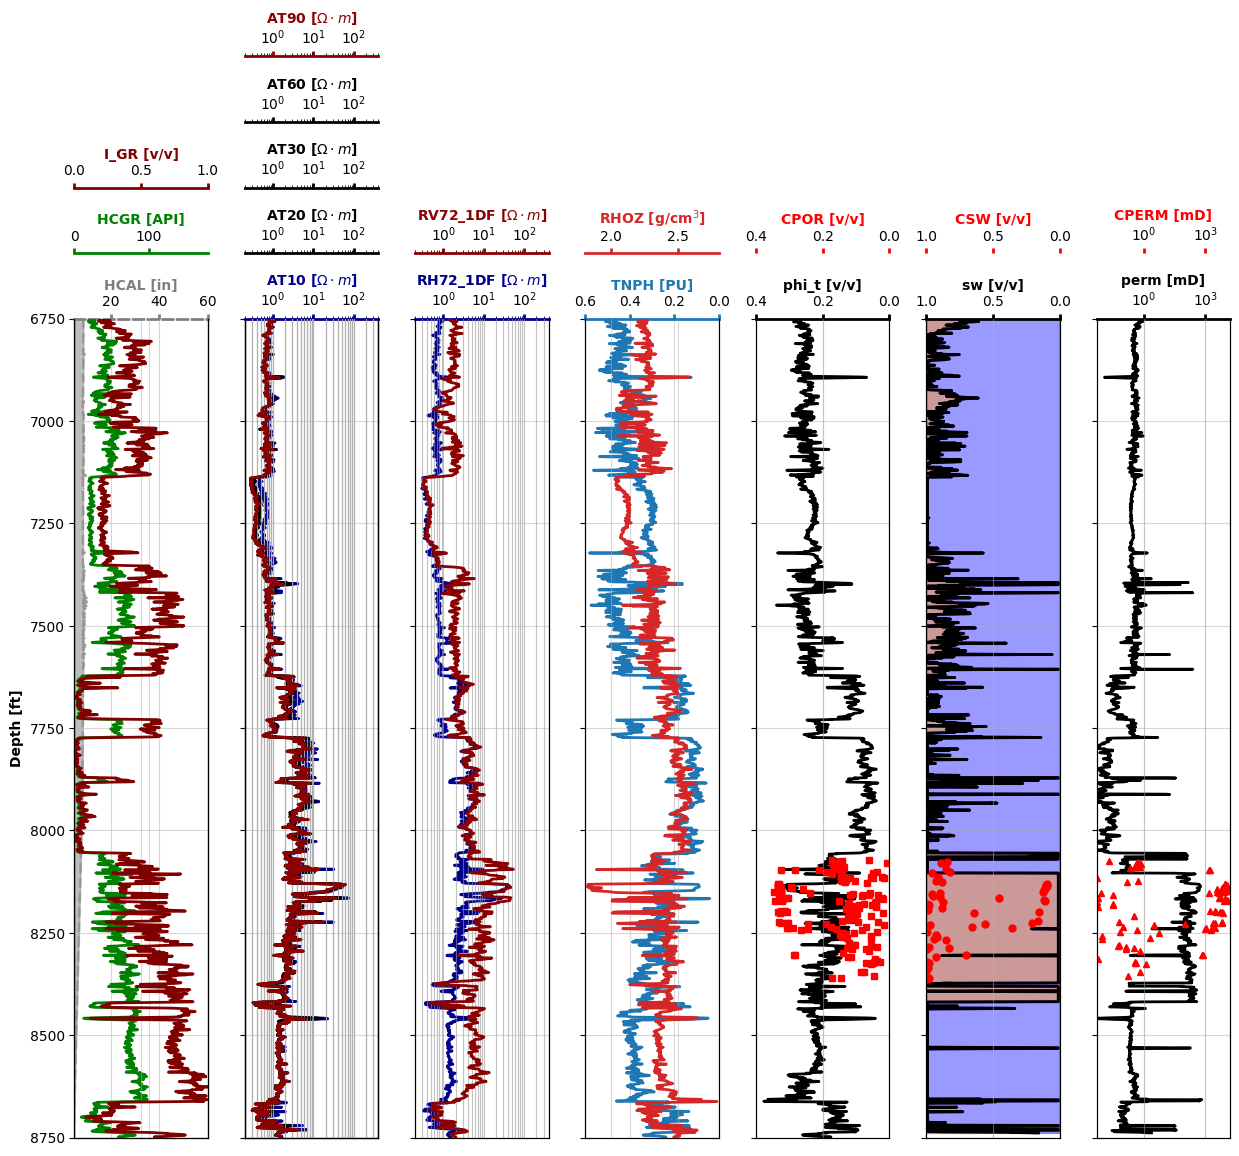

In [10]:
rlb, rub = 0.2, 400
fig, axs = plt.subplots(1, 7, figsize=(12.5, 12), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axs
ax11, ax12 = ax1.twiny(), ax1.twiny()
ax21, ax22, ax23, ax24 = ax2.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny()
ax31 = ax3.twiny()
ax41 = ax4.twiny()
ax51 = ax5.twiny()
ax61 = ax6.twiny()
ax71 = ax7.twiny()

plot_curve(ax1, d2, 'HCAL', lb=5, ub=60, units='in', color='tab:gray', ls='--', alpha=0.5, fill=True)
plot_curve(ax11, d2, 'HCGR', lb=0, ub=180, units='API', color='g', pad=8)
plot_curve(ax12, d2, 'igr', lb=0, ub=1, units='v/v', label='I_GR', color='maroon', pad=16)

plot_curve(ax2, d2, 'AT10', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax21, d2, 'AT20', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=8)
plot_curve(ax22, d2, 'AT30', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=16)
plot_curve(ax23, d2, 'AT60', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=24)
plot_curve(ax24, d2, 'AT90', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=32)

plot_curve(ax3, d2, 'RH72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax31, d2, 'RV72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=8)

plot_curve(ax4, d2, 'TNPH', lb=0.6, ub=0.0, units='PU', color='tab:blue')
plot_curve(ax41, d2, 'RHOZ', lb=1.81, ub=2.81, units=r'g/cm$^3$', color='tab:red', pad=8)

plot_curve(ax5, d2, 'phi_t', lb=0.4, ub=0.0, units='v/v', color='k')
plot_curve(ax51, c2, 'CPOR', lb=0.4, ub=0.0, units='v/v', color='r', ls='', marker='s', ms=5, pad=8)

plot_curve(ax6, d2, 'sw', lb=1, ub=0, units='v/v', color='maroon', fill=True, alpha=0.4)
plot_curve(ax6, d2, 'sw', lb=1, ub=0, units='v/v', color='b', fill=True, rightfill=True, alpha=0.4)
plot_curve(ax6, d2, 'sw', lb=1, ub=0, units='v/v', color='k')
plot_curve(ax61, c2, 'CSW', lb=1, ub=0, units='v/v', color='r', ls='', marker='o', ms=5, pad=8)

plot_curve(ax7, d2, 'perm', lb=0.005, ub=16e3, units='mD', color='k', semilog=True)
plot_curve(ax71, c2, 'CPERM', lb=0.005, ub=16e3, units='mD', color='r', ls='', marker='^', ms=5, semilog=True, pad=8)

ax1.set_ylabel('Depth [ft]', color='k', weight='bold')
ax1.set_ylim(start, end)
ax1.invert_yaxis()
plt.tight_layout()
plt.savefig('paper CDA/figures/d2_suite.png', dpi=300)
plt.show()

In [11]:
res2 = d2[['RV72_1DF', 'RH72_1DF', 'HCGR', 'Rvsh', 'Rhsh', 'RHOZ', 'TNPH', 'PHID_SS', 'AT10', 'AT90']].dropna()
res2.columns = ['Rv', 'Rh', 'GR', 'Rvsh', 'Rhsh', 'RHOB', 'NPHI', 'PHID_SS', 'AT10', 'AT90']

inputs = torch.tensor(res2.values, dtype=torch.float32).to(device)
dataset = TensorDataset(inputs)
train_percent = 0.8
n_train = int(train_percent*len(dataset))
xtrain, xvalid = random_split(dataset, [n_train, len(dataset)-n_train])
print('X_train: {} | X_valid: {}'.format(len(xtrain), len(xvalid)))

batch_size = 32
trainloader = DataLoader(xtrain, batch_size=batch_size, shuffle=True)
validloader = DataLoader(xvalid, batch_size=batch_size, shuffle=False)

model = ResInvPINN(hidden_dim=128).to(device)
criterion = PINNLoss(ddmax=res2['GR'].max(), lambda_reg=0, dd_flag=True).to(device)
mseloss = DataLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print('# of parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

epochs, monitor = 301, 100
pinn_lambda = 0.85
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    model.train()
    for i, x in enumerate(trainloader):
        optimizer.zero_grad()
        y = model(x[0])
        loss = (pinn_lambda)*criterion(x[0],y) + (1-pinn_lambda)*mseloss(x[0],y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for i, x in enumerate(validloader):
            y = model(x[0])
            loss = (pinn_lambda)*criterion(x[0],y) + (1-pinn_lambda)*mseloss(x[0],y)
            epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

losses = (train_loss, valid_loss)

X_train: 6400 | X_valid: 1601
# of parameters: 17,154
Epoch: 0 | Loss: 65.5487 | Valid Loss: 34.4886
Epoch: 100 | Loss: 4.5240 | Valid Loss: 2.9126
Epoch: 200 | Loss: 4.0476 | Valid Loss: 2.3827
Epoch: 300 | Loss: 3.7668 | Valid Loss: 5.7955


In [15]:
y_pred = model(inputs[:,:2]).cpu().detach().numpy().squeeze()
Csh_pred, Rss_pred = [y_pred[:,i] for i in range(y_pred.shape[1])]
print('Csh: min: {:.3f} | max: {:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_sim = (Csh_pred*res2['Rvsh'].values + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/res2['Rhsh'].values + (1-Csh_pred)/Rss_pred)
Rv_err = np.abs((Rv_sim - res2['Rv'].values)/res2['Rv'].values) * 100
Rh_err = np.abs((Rh_sim - res2['Rh'].values)/res2['Rh'].values) * 100
Csh_pred = MinMaxScaler((d2['igr'].min(), d2['igr'].max())).fit_transform(Csh_pred.reshape(-1, 1)).flatten()

# porosity
phi_d_corr = (res2['PHID_SS'] - Csh_pred * res2.loc[shale_point, 'PHID_SS']) / (1-Csh_pred)
phi_n_corr = (res2['NPHI'] - Csh_pred * res2.loc[shale_point, 'NPHI']) / (1-Csh_pred)
phi_ss = 0.5*np.sqrt(phi_d_corr**2 + phi_n_corr**2)
phi_pinn = (1-Csh_pred)*phi_ss + Csh_pred*phi_ss.loc[shale_point]

# resistivity & saturation
a, m, n = 1.0, 2.3, 2.0
rw = res2['AT90'][sand_point] * res2['PHID_SS'][sand_point]**m
sw = ((a*rw) / (Rss_pred*phi_pinn**m))**(1/n)
sw_pinn = sw.interpolate('polynomial', order=5).clip(0.01,0.99)

# permeability | a[100,1000], b[2,4], c[1.5,4]
aa, bb, cc = 10, 2.5, 1.5
perm_pinn = (aa * phi_pinn**bb) / (sw_pinn**cc)

pinn_results = pd.DataFrame({
    'Csh_pred': Csh_pred, 'Rss_pred': Rss_pred,
    'Rv_true': res2['Rv'].values, 
    'Rh_true': res2['Rh'].values,
    'Rv_sim': Rv_sim, 'Rh_sim': Rh_sim,
    'Rv_err': Rv_err, 'Rh_err': Rh_err,
    'phi_pinn': phi_pinn, 'sw_pinn': sw_pinn, 'perm_pinn': perm_pinn,
}, index=res2.index)

Csh: min: 0.001 | max: 0.797


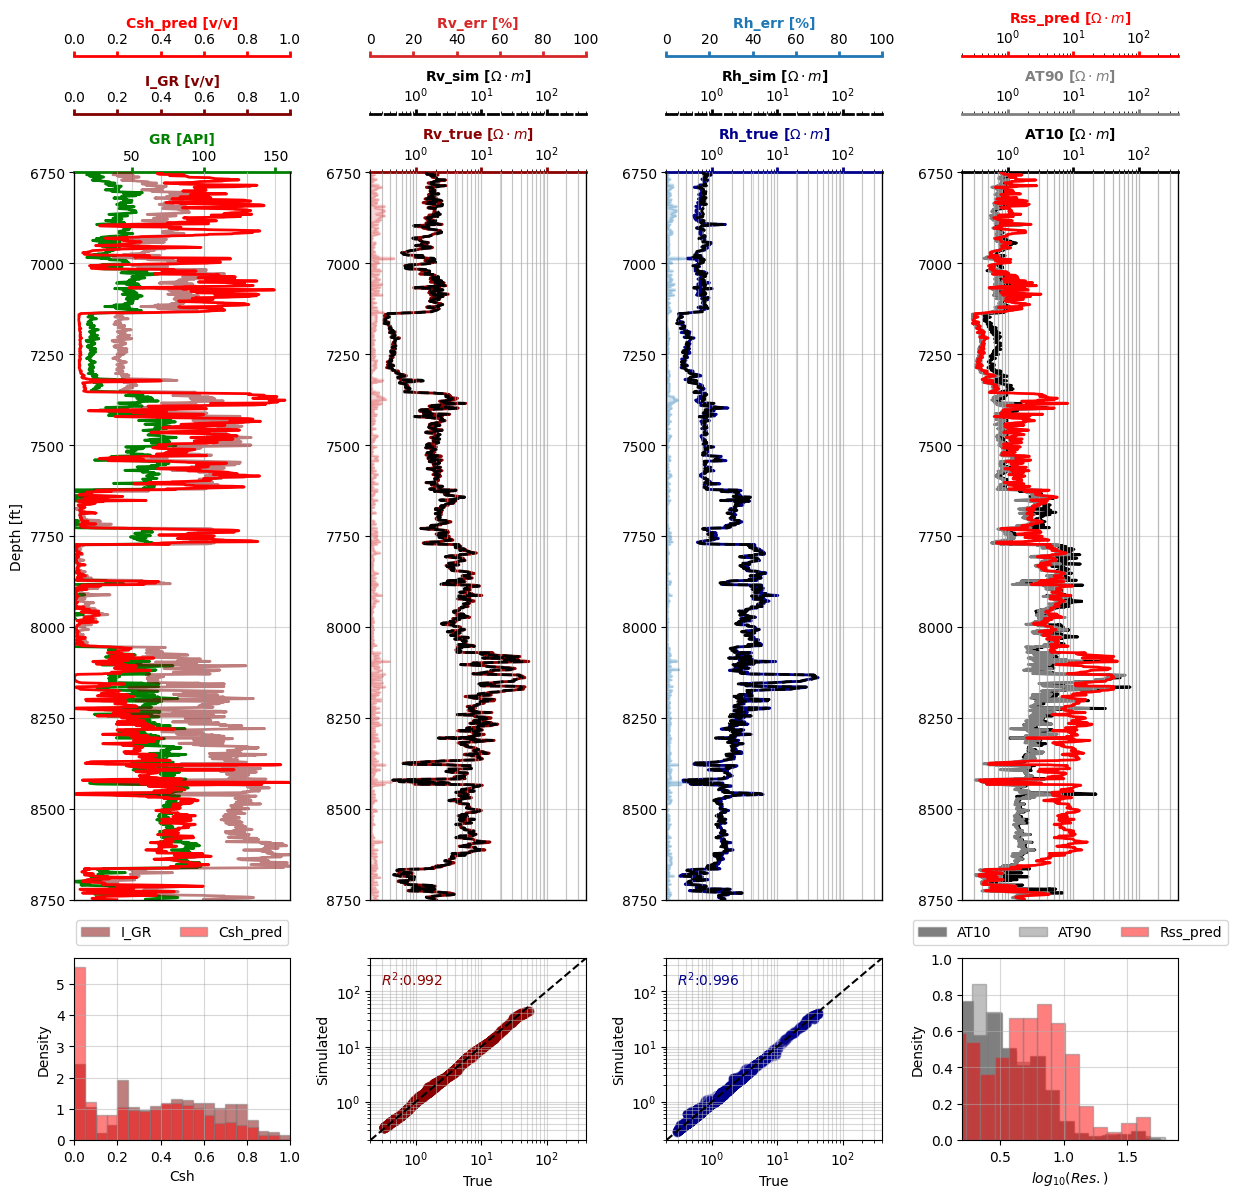

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(12.5, 12), height_ratios=[1, 0.25])
ax1, ax2, ax3, ax4 = axs[0,:]
ax11, ax12 = ax1.twiny(), ax1.twiny()
ax21, ax22 = ax2.twiny(), ax2.twiny()
ax31, ax32 = ax3.twiny(), ax3.twiny()
ax41, ax42 = ax4.twiny(), ax4.twiny()
ax1b, ax2b, ax3b, ax4b = axs[1,:]

plot_curve(ax1, res2, 'GR', lb=10, ub=160, units='API', color='g')
plot_curve(ax11, d2, 'igr', lb=0, ub=1, units='v/v', label='I_GR', color='maroon', alpha=0.5, pad=8)
plot_curve(ax12, pinn_results, 'Csh_pred', lb=0, ub=1, units='v/v', color='r', pad=16)

plot_curve(ax2, pinn_results, 'Rv_true', lb=rlb, ub=rub, units=r'$\Omega\cdot m$', color='darkred', semilog=True)
plot_curve(ax21, pinn_results, 'Rv_sim', lb=rlb, ub=rub, units=r'$\Omega\cdot m$', color='k', ls='--', semilog=True, pad=8)
plot_curve(ax22, pinn_results, 'Rv_err', lb=0, ub=100, units='%', color='tab:red', fill=True, alpha=0.2, mult=1/2, pad=16)

plot_curve(ax3, pinn_results, 'Rh_true', lb=rlb, ub=rub, units=r'$\Omega\cdot m$', color='darkblue', semilog=True)
plot_curve(ax31, pinn_results, 'Rh_sim', lb=rlb, ub=rub, units=r'$\Omega\cdot m$', color='k', ls='--', semilog=True, pad=8)
plot_curve(ax32, pinn_results, 'Rh_err', lb=0, ub=100, units='%', color='tab:blue', fill=True, alpha=0.2, mult=1/5, pad=16)

plot_curve(ax4, res2, 'AT10', lb=rlb, ub=rub, units=r'$\Omega\cdot m$', color='k', semilog=True)
plot_curve(ax41, res2, 'AT90', lb=rlb, ub=rub, units=r'$\Omega\cdot m$', color='gray', semilog=True, pad=8)
plot_curve(ax42, pinn_results, 'Rss_pred', lb=rlb, ub=rub, units=r'$\Omega\cdot m$', color='r', semilog=True, pad=16)

ax1b.hist(d2['igr'].loc[start:end], bins=20, density=True, color='maroon', edgecolor='gray', alpha=0.5, label='I_GR')
ax1b.hist(pinn_results['Csh_pred'].loc[start:end], bins=20, density=True, color='r', edgecolor='gray', alpha=0.5, label='Csh_pred')
ax1b.set(xlabel='Csh', ylabel='Density', xlim=(0,1), ylim=(0, None))
ax1b.legend(loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.25))

ax2b.scatter(pinn_results['Rv_true'], pinn_results['Rv_sim'], c='darkred', alpha=0.25)
ax3b.scatter(pinn_results['Rh_true'], pinn_results['Rh_sim'], c='darkblue', alpha=0.25)
ax2b.text(0.05, 0.85, r'$R^2$:{:.3f}'.format(r2_score(pinn_results['Rv_true'], pinn_results['Rv_sim'])), transform=ax2b.transAxes, color='darkred', fontsize=10)
ax3b.text(0.05, 0.85, r'$R^2$:{:.3f}'.format(r2_score(pinn_results['Rh_true'], pinn_results['Rh_sim'])), transform=ax3b.transAxes, color='darkblue', fontsize=10)
[a.axline((0,0),(1,1), color='k', ls='--') for a in [ax2b, ax3b]]

ax4b.hist(np.log10(d2['AT10'].loc[start:end]), bins=20, density=True, color='k', edgecolor='gray', alpha=0.5, label='AT10')
ax4b.hist(np.log10(d2['AT90'].loc[start:end]), bins=20, density=True, color='gray', edgecolor='gray', alpha=0.5, label='AT90')
ax4b.hist(np.log10(pinn_results['Rss_pred'].loc[start:end]), bins=20, density=True, color='r', edgecolor='gray', alpha=0.5, label='Rss_pred')
ax4b.set(xlabel=r'$log_{10}(Res.)$', ylabel='Density', xlim=(rlb,1.9), ylim=(0, 1))
ax4b.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.25))

[a.grid(True, which='both', alpha=0.5) for a in [ax1b, ax2b, ax3b, ax4b]]
[a.set(xscale='log', yscale='log', xlabel='True', ylabel='Simulated', xlim=(rlb,rub), ylim=(rlb,rub)) for a in [ax2b, ax3b]]
ax1.set(ylabel='Depth [ft]')
[a.set_ylim(start, end) for a in [ax1, ax2, ax3, ax4]]
[a.invert_yaxis() for a in [ax1, ax2, ax3, ax4]]
plt.tight_layout()
plt.savefig('paper CDA/figures/d2_pinn_new.png', dpi=300)
plt.show()

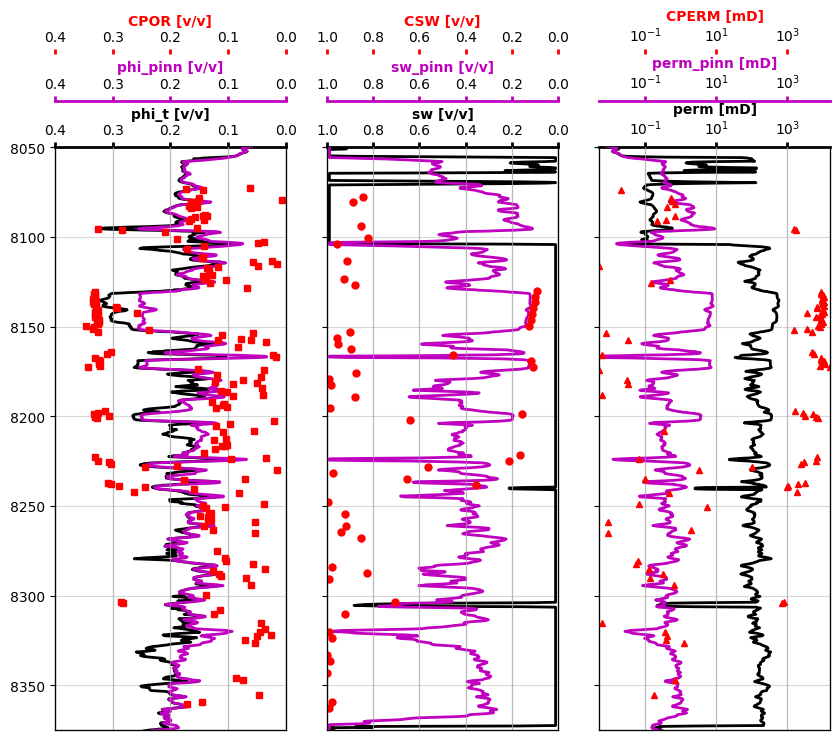

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 7.5), sharey=True)
ax1, ax2, ax3 = axs
ax11, ax12 = ax1.twiny(), ax1.twiny()
ax21, ax22 = ax2.twiny(), ax2.twiny()
ax31, ax32 = ax3.twiny(), ax3.twiny()

plot_curve(ax1, d2, 'phi_t', lb=0.4, ub=0, units='v/v', color='k')
plot_curve(ax11, pinn_results, 'phi_pinn', lb=0.4, ub=0, units='v/v', color='m', pad=8)
plot_curve(ax12, c2, 'CPOR', lb=0.4, ub=0, units='v/v', color='r', ls='', marker='s', ms=5, pad=16)

plot_curve(ax2, d2, 'sw', lb=1, ub=0, units='v/v', color='k')
plot_curve(ax21, pinn_results, 'sw_pinn', lb=1, ub=0, units='v/v', color='m', pad=8)
plot_curve(ax22, c2, 'CSW', lb=1, ub=0, units='v/v', color='r', ls='', marker='o', ms=5, pad=16)

plot_curve(ax3, d2, 'perm', lb=0.005, ub=16e3, units='mD', color='k', semilog=True)
plot_curve(ax31, pinn_results, 'perm_pinn', lb=0.005, ub=16e3, units='mD', color='m', semilog=True, pad=8)
plot_curve(ax32, c2, 'CPERM', lb=0.005, ub=16e3, units='mD', color='r', ls='', marker='^', ms=5, semilog=True, pad=16)

ax1.set(ylim=(8050,8375))
ax1.invert_yaxis()
plt.tight_layout()
plt.savefig('paper CDA/figures/d2_est.png', dpi=300)
plt.show()

In [18]:
nuq = 300
a, m, n = 1.0, 2.3, 2.0
aa, bb, cc = 10, 2.5, 1.5

poro_prior = np.zeros((nuq, pinn_results.shape[0]))
sw_prior = np.zeros((nuq, pinn_results.shape[0]))
perm_prior = np.zeros((nuq, pinn_results.shape[0]))

for i in tqdm(range(nuq), desc='Generating Priors'):
    dd = res2 + np.random.normal(0, 0.1*res2.std(0), size=res2.shape)
    xx = torch.tensor(dd[['Rv','Rh']].values, dtype=torch.float32).to(device)
    rr = model(xx).cpu().detach().numpy().squeeze()
    csh_uq, rss_uq = rr[:,0], rr[:,1]
    csh_uq = MinMaxScaler((d2['igr'].min(), d2['igr'].max())).fit_transform(csh_uq.reshape(-1, 1)).flatten().clip(0.005, 0.995)

    d = (dd['PHID_SS'] - csh_uq * dd.loc[shale_point, 'PHID_SS']) / (1-csh_uq)
    n = (dd['NPHI'] - csh_uq * dd.loc[shale_point, 'NPHI']) / (1-csh_uq)
    s = 0.5*np.sqrt(d**2 + n**2)
    poro_prior[i] = (1-csh_uq)*s + csh_uq * s[shale_point]
    
    ss = pinn_results['sw_pinn'].values + np.random.lognormal(0, 0.25*pinn_results['sw_pinn'].std(), size=pinn_results.shape[0])
    sw_prior[i] = MinMaxScaler((0.02,0.98)).fit_transform(ss.reshape(-1, 1)).flatten()
    kk = pinn_results['perm_pinn'].values + np.random.lognormal(0, 0.5*pinn_results['perm_pinn'].std(), size=pinn_results.shape[0])
    perm_prior[i] = MinMaxScaler((c2['CPERM'].min(), c2['CPERM'].max())).fit_transform(kk.reshape(-1, 1)).flatten()

poro_prior = pd.DataFrame(poro_prior.T, index=pinn_results.index)
sw_prior = pd.DataFrame(sw_prior.T, index=pinn_results.index)
perm_prior = pd.DataFrame(perm_prior.T, index=pinn_results.index).replace(np.nan, perm_prior.mean(axis=0)[0])
print('Porosity Prior: shape: {} | min: {:.3f}  | max: {:.3f} | nan: {}'.format(poro_prior.shape, np.min(poro_prior), np.max(poro_prior), np.sum(np.isnan(poro_prior.values))))
print('Sw Prior:       shape: {} | min: {:.3f} | max: {:.3f} | nan: {}'.format(sw_prior.shape, np.min(sw_prior), np.max(sw_prior), np.sum(np.isnan(sw_prior.values))))
print('Perm Prior:     shape: {} | min: {:.3f} | max: {:.3f} | nan: {}'.format(perm_prior.shape, np.min(perm_prior), np.max(perm_prior), np.sum(np.isnan(perm_prior.values))))

Generating Priors: 100%|██████████| 300/300 [00:02<00:00, 135.29it/s]

Porosity Prior: shape: (8001, 300) | min: 0.008  | max: 0.457 | nan: 0
Sw Prior:       shape: (8001, 300) | min: 0.020 | max: 0.980 | nan: 0
Perm Prior:     shape: (8001, 300) | min: 0.005 | max: 15490.000 | nan: 0


In [19]:
idx_log = res2.index.values
idx_por = c2['CPOR'].dropna().index.values
idx_sw = c2['CSW'].dropna().index.values
idx_perm = c2['CPERM'].dropna().index.values

y_obs_poro = c2['CPOR'].loc[idx_por].values
y_obs_sw = c2['CSW'].loc[idx_sw].values
y_obs_perm = c2['CPERM'].loc[idx_perm].values

poro_posterior = esmda_assimilation(poro_prior.T, y_obs_poro, np.where(np.isin(idx_log, idx_por))[0], gamma=50)
sw_posterior = esmda_assimilation(sw_prior.T, y_obs_sw, np.where(np.isin(idx_log, idx_sw))[0], gamma=5)
perm_posterior = esmda_assimilation(perm_prior.T, y_obs_perm, np.where(np.isin(idx_log, idx_perm))[0], gamma=5).clip(c2['CPERM'].min(), c2['CPERM'].max())

poro_posterior = pd.DataFrame(poro_posterior.T, index=pinn_results.index)
sw_posterior = pd.DataFrame(sw_posterior.T, index=pinn_results.index)
perm_posterior = pd.DataFrame(perm_posterior.T, index=pinn_results.index).replace(np.nan, perm_posterior.mean(axis=0)[0])

print('Porosity: mean: {:.3f}-{:.3f} | min: {:.3f}-{:.3f} | max: {:.3f}-{:.3f}'.format(np.mean(poro_prior.values), np.mean(poro_posterior.values),
    np.min(poro_prior.values), np.min(poro_posterior.values), np.max(poro_prior.values), np.max(poro_posterior.values)))
print('Sw:       mean: {:.3f}-{:.3f} | min: {:.3f}-{:.3f} | max: {:.3f}-{:.3f}'.format(np.mean(sw_prior.values), np.mean(sw_posterior.values),
    np.min(sw_prior.values), np.min(sw_posterior.values), np.max(sw_prior.values), np.max(sw_posterior.values)))
print('Perm:     mean: {:.2f}-{:.2f} | min: {:.2f}-{:.2f} | max: {:.2f}-{:.2f}'.format(np.mean(perm_prior.values), np.mean(perm_posterior.values),
    np.min(perm_prior.values), np.min(perm_posterior.values), np.max(perm_prior.values), np.max(perm_posterior.values)))

Porosity: mean: 0.191-0.171 | min: 0.008--0.962 | max: 0.457-0.998
Sw:       mean: 0.584-0.852 | min: 0.020-0.151 | max: 0.980-1.366
Perm:     mean: 2076.07-1356.23 | min: 0.00-0.01 | max: 15490.00-13273.79


In [20]:
print('-'*24+' '+'Porosity Uncertainty Quantification'+' '+'-'*24)
phi_uq, phi_uq_diff, phi_dyk, phi_ratio = calculate_uncertainty(
    c2['CPOR'].dropna().values,
    d2['phi_t'].dropna().values,
    pinn_results['phi_pinn'].dropna().values,
    poro_prior.values.flatten(),
    poro_posterior.values.flatten())

print('\n')
print('-'*27+' '+'Sw Uncertainty Quantification'+' '+'-'*27)
sw_uq, sw_uq_diff, sw_dyk, sw_ratio = calculate_uncertainty(
    c2['CSW'].dropna().values,
    d2['sw'].dropna().values,
    pinn_results['sw_pinn'].dropna().values,
    sw_prior.values.flatten(),
    sw_posterior.values.flatten())

print('\n')
print('-'*20+' '+'Permeability Uncertainty Quantification'+' '+'-'*20)
perm_uq, perm_uq_diff, perm_dyk, perm_ratio = calculate_uncertainty(
    c2['CPERM'].dropna().values,
    d2['perm'].dropna().values,
    pinn_results['perm_pinn'].dropna().values,
    perm_prior.values.flatten(),
    perm_posterior.values.flatten())


------------------------ Porosity Uncertainty Quantification ------------------------
Uncertainty:      Core=0.286 | Log=0.184 | PINN=0.178 | Prior=0.182 | Posterior=0.283
Uncertainty Diff:               Log=35.59 | PINN=37.58 | Prior=36.26 | Posterior=0.94
Dykstra-Parsons:  Core=0.595 | Log=0.523 | PINN=0.508 | Prior=0.508 | Posterior=0.657
Dykstra-Parsons Ratio:          Log=0.878 | PINN=0.853 | Prior=0.854 | Posterior=1.103


--------------------------- Sw Uncertainty Quantification ---------------------------
Uncertainty:      Core=0.878 | Log=0.980 | PINN=0.667 | Prior=0.538 | Posterior=0.490
Uncertainty Diff:               Log=11.64 | PINN=23.98 | Prior=38.74 | Posterior=44.22
Dykstra-Parsons:  Core=0.857 | Log=0.990 | PINN=0.528 | Prior=0.485 | Posterior=0.286
Dykstra-Parsons Ratio:          Log=1.155 | PINN=0.616 | Prior=0.566 | Posterior=0.334


-------------------- Permeability Uncertainty Quantification --------------------
Uncertainty:      Core=10074.369 | Log=130.256 | PI

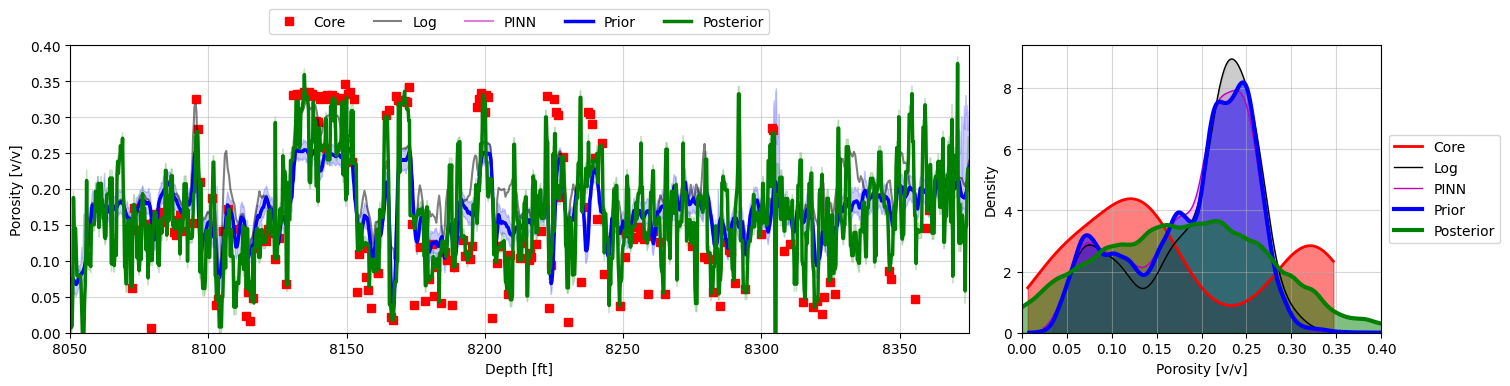

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15,4), width_ratios=[1, 0.4])
ax1, ax2 = axs

ax1.plot(c2.index, c2['CPOR'], label='Core', color='r', ls='', marker='s')
ax1.plot(d2.index, d2['phi_t'], label='Log', color='k', alpha=0.5)
ax1.plot(pinn_results.index, phi_pinn.values, label='PINN', color='m', alpha=0.5)

ax1.plot(pinn_results.index, poro_prior.mean(axis=1), color='b', label='Prior', lw=2.5)
ax1.fill_between(pinn_results.index, poro_prior.min(axis=1), poro_prior.max(axis=1), color='b', alpha=0.2)

ax1.plot(pinn_results.index, poro_posterior.mean(axis=1), color='g', label='Posterior', lw=2.5)
ax1.fill_between(pinn_results.index, poro_posterior.min(axis=1), poro_posterior.max(axis=1), color='g', alpha=0.2)

plot_pdf(ax2, c2['CPOR'].dropna().values, color='r', label='Core', alpha=0.5, lw=2)
plot_pdf(ax2, d2['phi_t'].dropna().values, color='k', label='Log', alpha=0.2, lw=1)
plot_pdf(ax2, pinn_results['phi_pinn'].dropna().values, color='m', label='PINN', alpha=0.2, lw=1)
plot_pdf(ax2, poro_prior.values.flatten(), color='b', label='Prior', alpha=0.5, lw=3)
plot_pdf(ax2, poro_posterior.values.flatten(), color='g', label='Posterior', alpha=0.5, lw=3)

ax2.set(xlabel='Porosity [v/v]', ylabel='Density', xlim=(0, 0.4), ylim=(0,None))
ax2.legend(loc='center right', ncols=1 , fancybox=True, bbox_to_anchor=(1.35, 0.5))

ax1.set(xlim=(8050,8375), ylim=(0, 0.4))
ax1.set(xlabel='Depth [ft]', ylabel='Porosity [v/v]')
ax1.legend(loc='upper center', ncols=5 , fancybox=True, bbox_to_anchor=(0.5, 1.15))
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.savefig('paper CDA/figures/d2_uq_poro.png', dpi=300)
plt.show()

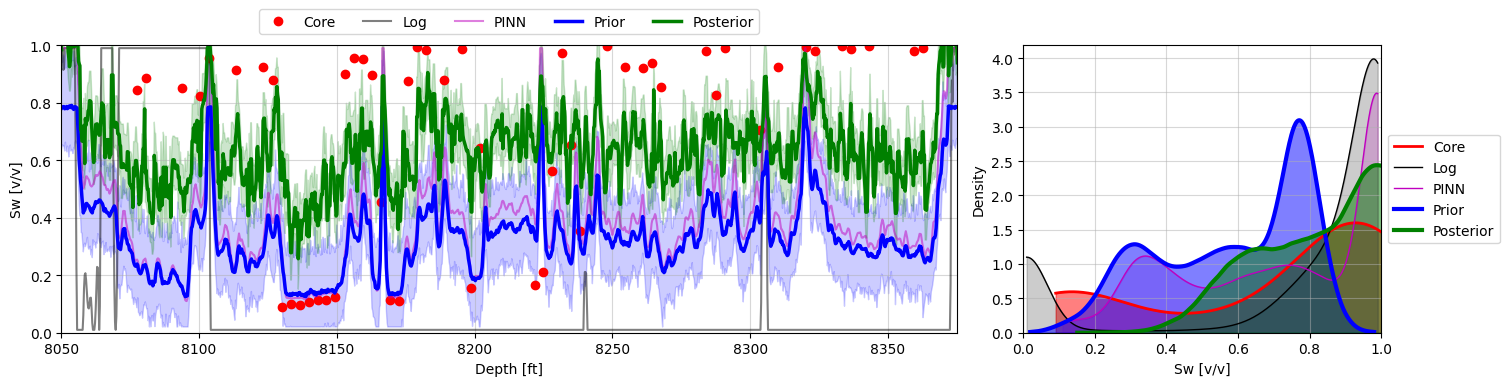

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15,4), width_ratios=[1, 0.4])
ax1, ax2 = axs

ax1.plot(c2.index, c2['CSW'], label='Core', color='r', ls='', marker='o')
ax1.plot(d2.index, d2['sw'], label='Log', color='k', alpha=0.5)
ax1.plot(sw_pinn.index, sw_pinn.values, label='PINN', color='m', alpha=0.5)

ax1.plot(pinn_results.index, sw_prior.mean(axis=1), color='b', label='Prior', lw=2.5)
ax1.fill_between(pinn_results.index, sw_prior.min(axis=1), sw_prior.max(axis=1), color='b', alpha=0.2)

ax1.plot(pinn_results.index, sw_posterior.mean(axis=1), color='g', label='Posterior', lw=2.5)
ax1.fill_between(pinn_results.index, sw_posterior.min(axis=1), sw_posterior.max(axis=1), color='g', alpha=0.2)

plot_pdf(ax2, c2['CSW'].dropna().values, color='r', label='Core', alpha=0.5, lw=2)
plot_pdf(ax2, d2['sw'].dropna().values, color='k', label='Log', alpha=0.2, lw=1)
plot_pdf(ax2, pinn_results['sw_pinn'].dropna().values, color='m', label='PINN', alpha=0.2, lw=1)
plot_pdf(ax2, sw_prior.values.flatten(), color='b', label='Prior', alpha=0.5, lw=3)
plot_pdf(ax2, sw_posterior.values.flatten(), color='g', label='Posterior', alpha=0.5, lw=3)

ax2.set(xlabel='Sw [v/v]', ylabel='Density', xlim=(0,1), ylim=(0,None))
ax2.legend(loc='center right', ncols=1 , fancybox=True, bbox_to_anchor=(1.35, 0.5))

ax1.set(xlim=(8050,8375), ylim=(0, 1))
ax1.set(xlabel='Depth [ft]', ylabel='Sw [v/v]')
ax1.legend(loc='upper center', ncols=5 , fancybox=True, bbox_to_anchor=(0.5, 1.15))
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.savefig('paper CDA/figures/d2_uq_sw.png', dpi=300)
plt.show()

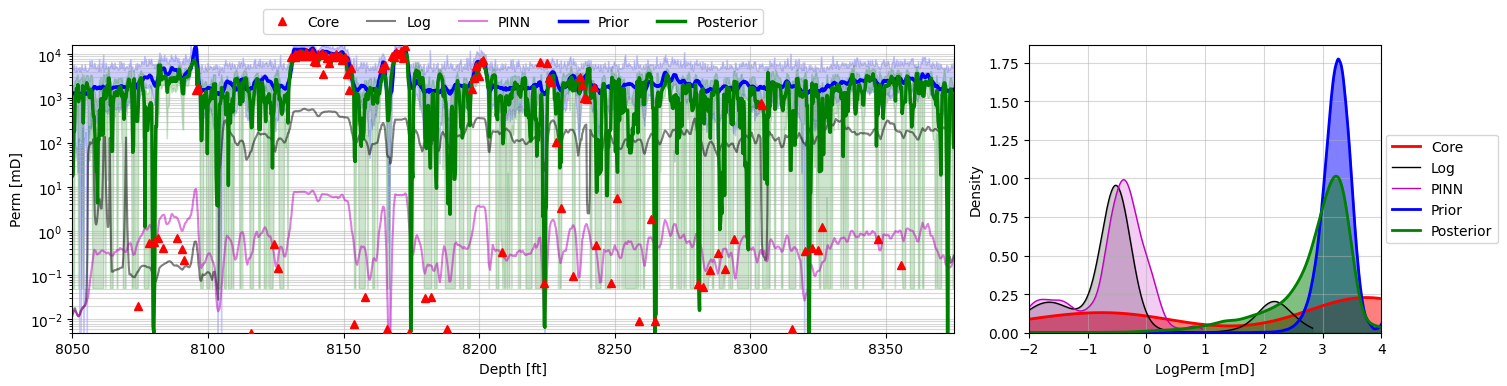

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,4), width_ratios=[1, 0.4])
ax1, ax2 = axs

ax1.plot(c2.index, c2['CPERM'], label='Core', color='r', ls='', marker='^', zorder=5)
ax1.plot(d2.index, d2['perm'], label='Log', color='k', alpha=0.5)
ax1.plot(perm_pinn.index, perm_pinn.values, label='PINN', color='m', alpha=0.5)

kk = perm_prior
ax1.plot(pinn_results.index, kk.mean(axis=1), color='b', label='Prior', lw=2.5)
ax1.fill_between(pinn_results.index, kk.min(axis=1), kk.max(axis=1), color='b', alpha=0.2)

ax1.plot(pinn_results.index, perm_posterior.mean(axis=1), color='g', label='Posterior', lw=2.5)
ax1.fill_between(pinn_results.index, perm_posterior.min(axis=1), perm_posterior.max(axis=1), color='g', alpha=0.2)

plot_pdf(ax2, np.log10(c2['CPERM'].dropna().values), color='r', label='Core', alpha=0.5, lw=2)
plot_pdf(ax2, np.log10(d2['perm'].dropna().values), color='k', label='Log', alpha=0.2, lw=1)
plot_pdf(ax2, np.log10(pinn_results['perm_pinn'].dropna().values), color='m', label='PINN', alpha=0.2, lw=1)
plot_pdf(ax2, np.log10(np.abs(perm_prior.dropna().values.flatten())), color='b', label='Prior', alpha=0.5)
#plot_pdf(ax2, np.log10(np.abs(perm_posterior.replace(0,np.nan).dropna().values.flatten())), color='g', label='Posterior', alpha=0.5)
plot_pdf(ax2, np.log10(np.nanmean(perm_posterior, axis=1)), color='g', label='Posterior', alpha=0.5)

ax2.set(xlabel='LogPerm [mD]', ylabel='Density', xlim=(-2, 4), ylim=(0,None))
ax2.legend(loc='center right', ncols=1 , fancybox=True, bbox_to_anchor=(1.35, 0.5))

ax1.set(yscale='log', xlim=(8050,8375), ylim=(0.005, 16e3), xlabel='Depth [ft]', ylabel='Perm [mD]')
ax1.legend(loc='upper center', ncols=5 , fancybox=True, bbox_to_anchor=(0.5, 1.15))
[a.grid(True, which='both', alpha=0.5) for a in axs]
plt.tight_layout()
plt.savefig('paper CDA/figures/d2_uq_perm.png', dpi=300)
plt.show()

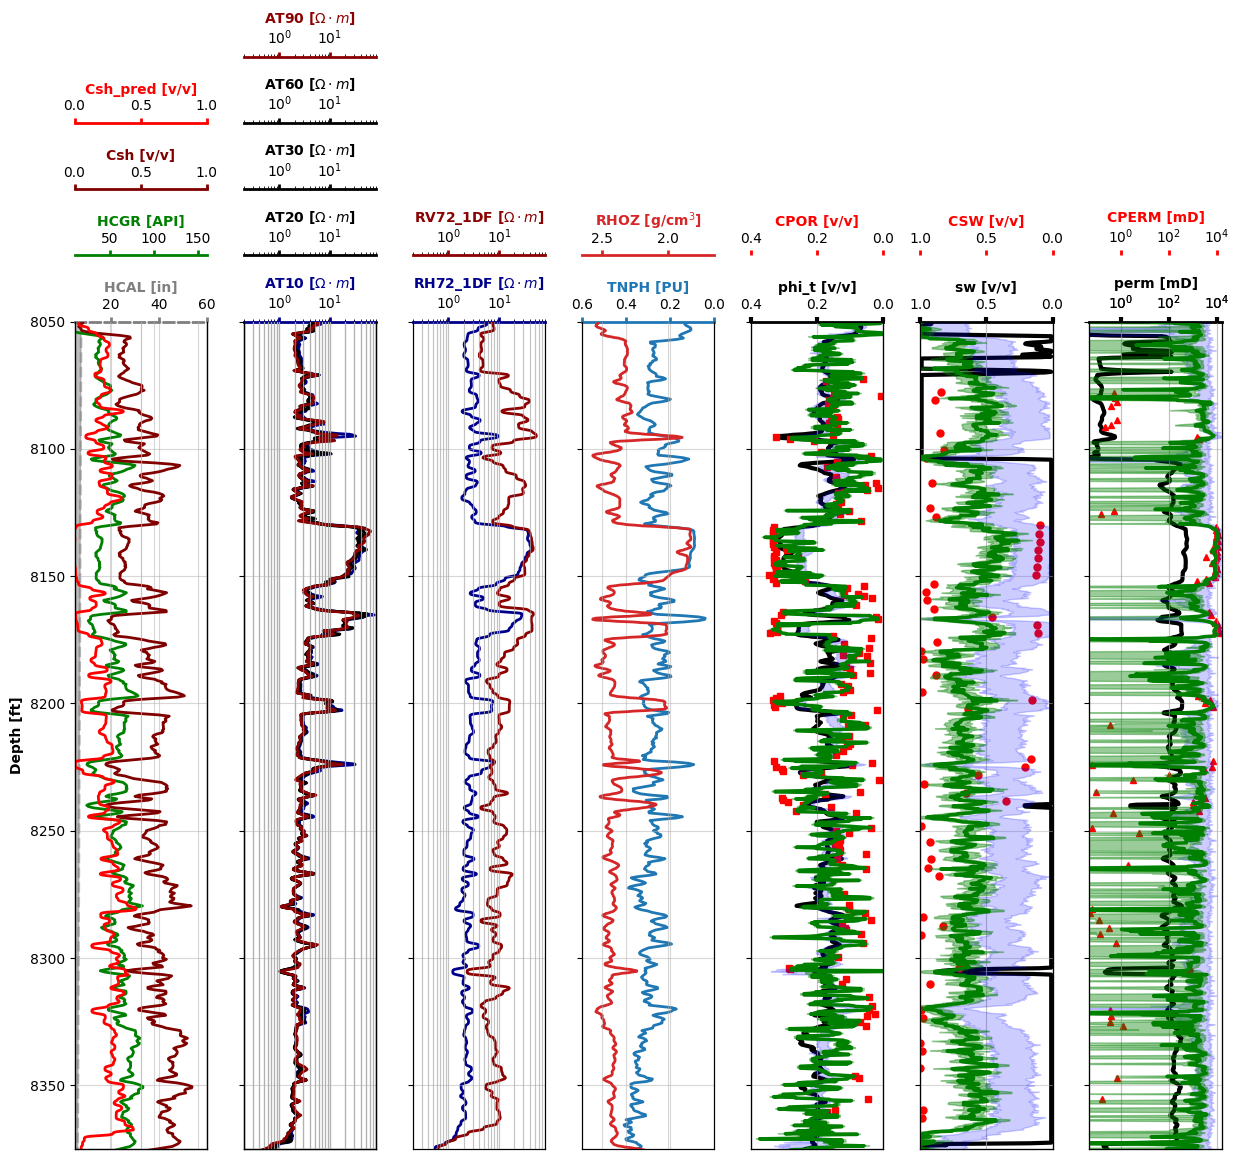

In [44]:
rlb, rub = 0.2, 80
fig, axs = plt.subplots(1, 7, figsize=(12.5, 12), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axs
ax11, ax12, ax13 = ax1.twiny(), ax1.twiny(), ax1.twiny()
ax21, ax22, ax23, ax24 = ax2.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny()
ax31, ax41, ax51, ax61, ax71 = ax3.twiny(), ax4.twiny(), ax5.twiny(), ax6.twiny(), ax7.twiny()
ax52, ax62, ax72 = ax5.twiny(), ax6.twiny(), ax7.twiny()

plot_curve(ax1, d2, 'HCAL', lb=5, ub=60, units='in', color='tab:gray', ls='--', alpha=0.5, fill=True)
plot_curve(ax11, d2, 'HCGR', units='API', lb=10, ub=160, color='g', pad=8)
plot_curve(ax12, d2, 'igr', lb=0, ub=1, units='v/v', label='Csh', color='maroon', pad=16)
plot_curve(ax13, pinn_results, 'Csh_pred', lb=0, ub=1, units='v/v', color='r', pad=24)

plot_curve(ax2, d2, 'AT10', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax21, d2, 'AT20', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=8)
plot_curve(ax22, d2, 'AT30', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=16)
plot_curve(ax23, d2, 'AT60', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=24)
plot_curve(ax24, d2, 'AT90', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=32)

plot_curve(ax3, d2, 'RH72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax31, d2, 'RV72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=8)

plot_curve(ax4, d2, 'TNPH', units='PU', lb=0.6, ub=0.0, color='tab:blue')
plot_curve(ax41, d2, 'RHOZ', units=r'g/cm$^3$', lb=2.65, ub=1.65, color='tab:red', pad=8)

plot_curve(ax5, d2, 'phi_t', lb=0.4, ub=0, units='v/v', color='k', s=3)
plot_curve(ax51, c2, 'CPOR', lb=0.4, ub=0, units='v/v', color='r', ls='', marker='s', ms=5, pad=8)
ax52.fill_betweenx(poro_prior.index, poro_prior.min(axis=1), poro_prior.max(axis=1), color='b', alpha=0.2)
ax52.fill_betweenx(poro_posterior.index, poro_posterior.min(axis=1), poro_posterior.max(axis=1), color='g', alpha=0.4)
ax52.plot(poro_posterior.mean(axis=1), poro_posterior.index, color='g', label='Posterior', lw=2.5)
ax52.set(xticks=[], xticklabels=[], xlim=(0.4,0))

plot_curve(ax6, d2, 'sw', lb=1, ub=0, units='v/v', color='k', s=3)
plot_curve(ax61, c2, 'CSW', lb=1, ub=0, units='v/v', color='r', ls='', marker='o', ms=5, pad=8)
ax62.fill_betweenx(sw_prior.index, sw_prior.min(axis=1), sw_prior.max(axis=1), color='b', alpha=0.2)
ax62.fill_betweenx(sw_posterior.index, sw_posterior.min(axis=1), sw_posterior.max(axis=1), color='g', alpha=0.4)
ax62.plot(sw_posterior.mean(axis=1), sw_posterior.index, color='g', label='Posterior', lw=2.5)
ax62.set(xticks=[], xticklabels=[], xlim=(1,0))

plot_curve(ax7, d2, 'perm', lb=0.05, ub=16e3, units='mD', color='k', semilog=True, s=3)
plot_curve(ax71, c2, 'CPERM', lb=0.05, ub=16e3, units='mD', color='r', ls='', marker='^', ms=5, semilog=True, pad=8, zorder=0)
ax72.fill_betweenx(perm_prior.index, perm_prior.min(axis=1)-2.5, perm_prior.max(axis=1)-200, color='b', alpha=0.2)
ax72.fill_betweenx(perm_posterior.index, perm_posterior.min(axis=1), perm_posterior.max(axis=1), color='g', alpha=0.4)
ax72.plot(perm_posterior.mean(axis=1), perm_posterior.index, color='g', label='Posterior', lw=2.5)
ax72.set(xticks=[], xticklabels=[], xlim=(0.05,16e3), xscale='log')

ax1.set_ylabel('Depth [ft]', color='k', weight='bold')
ax1.set_ylim(8050,8375)
ax1.invert_yaxis()
plt.tight_layout()
plt.savefig('paper CDA/figures/d2_uq_suite_new.png', dpi=300)
plt.show()

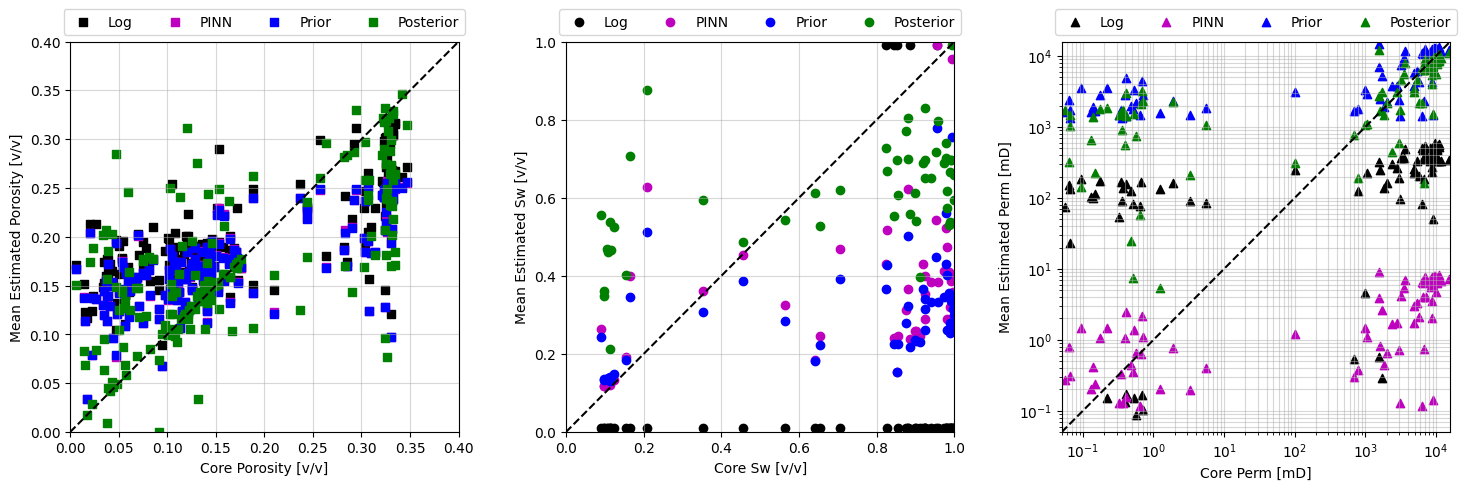

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
ax1, ax2, ax3 = axs

ax1.scatter(c2['CPOR'].loc[idx_por], d2['phi_t'].loc[idx_por], marker='s', label='Log', c='k')
ax2.scatter(c2['CSW'].loc[idx_sw], d2['sw'].loc[idx_sw], marker='o', label='Log', c='k')
ax3.scatter(c2['CPERM'].loc[idx_perm], d2['perm'].loc[idx_perm], marker='^', label='Log', c='k')

ax1.scatter(c2['CPOR'].loc[idx_por], pinn_results['phi_pinn'].loc[idx_por], marker='s', label='PINN', c='m')
ax2.scatter(c2['CSW'].loc[idx_sw], pinn_results['sw_pinn'].loc[idx_sw], marker='o', label='PINN', c='m')
ax3.scatter(c2['CPERM'].loc[idx_perm], pinn_results['perm_pinn'].loc[idx_perm], marker='^', label='PINN', c='m')

ax1.scatter(c2['CPOR'].loc[idx_por], poro_prior.mean(1).loc[idx_por], marker='s', label='Prior', c='b')
ax2.scatter(c2['CSW'].loc[idx_sw], sw_prior.mean(1).loc[idx_sw], marker='o', label='Prior', c='b')
ax3.scatter(c2['CPERM'].loc[idx_perm], perm_prior.mean(1).loc[idx_perm], marker='^', label='Prior', c='b')

ax1.scatter(c2['CPOR'].loc[idx_por], poro_posterior.mean(1).loc[idx_por], marker='s', label='Posterior', c='g')
ax2.scatter(c2['CSW'].loc[idx_sw], sw_posterior.mean(1).loc[idx_sw], marker='o', label='Posterior', c='g')
ax3.scatter(c2['CPERM'].loc[idx_perm], perm_posterior.mean(1).loc[idx_perm], marker='^', label='Posterior', c='g')

[a.axline((0,0),(1,1), color='k', ls='--') for a in [ax1, ax2, ax3]]
ax1.set(xlim=(0,0.4), ylim=(0,0.4), xlabel='Core Porosity [v/v]', ylabel='Mean Estimated Porosity [v/v]')
ax2.set(xlim=(0,1), ylim=(0,1), xlabel='Core Sw [v/v]', ylabel='Mean Estimated Sw [v/v]')
ax3.set(xlim=(0.05,16e3), ylim=(0.05,16e3), xlabel='Core Perm [mD]', ylabel='Mean Estimated Perm [mD]', xscale='log', yscale='log')
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.legend(loc='upper center', ncols=4, fancybox=True, bbox_to_anchor=(0.5, 1.1)) for a in axs]

plt.tight_layout()
plt.savefig('paper CDA/figures/d2_uq_scatter.png', dpi=300)
plt.show()

***
# END